### Tutorial 7 - Trainig a PyTorch Lightning model

In this tutorial, we will train a simple U-Net model for regression using PyTorch Lightning. For sake of simplicity, we generate random data and label in order to train.
The data is a 1-channel 2D image, with shape `(1, 128, 128)`. As it is a regression task, the label is a 1-channel 2D image with the same shape.

Thus, in this tutorial, we will:
1. Generate 16 samples of random data and label, with shape `(1, 128, 128)`.
2. Create a DASF map-style like dataset, named `LabeledDataset`. This dataset implements the `__getitem__` and `__len__` methods. The `__getitem__` method returns 2-element tuple with the data and label. The return data may be in numpy, cupy or dask array format. Note that we can create complex pipelines of data using DASF operator. For now, we use only the `DatasetArray` operator, but we can chain other Dasd operator. It is important that, the input to `LightningTrainer` is a map-style dataset that returns a 2-element tuple for each index.
3. Create a U-Net model.
4. Train the model using PyTorch Lightning and Dasf.


#### Considerations and still going work

- We still cannot use the GPU in this notebook environments, but it works fine in python scripts.
- This tutorial is a work in progress and will be updated with more details and explanations.

In [1]:
from minerva.models.nets.unet import UNet
from dasf.datasets import Dataset, DatasetArray
from dasf.pipeline import Pipeline
from dasf.pipeline.executors import DaskPipelineExecutor
import lightning as L
from dasf.ml.dl import LightningTrainer
import numpy as np
from typing import List, Tuple

[1715635051.633686] [d78f44b0045f:277372:f]        vfs_fuse.c:281  UCX  ERROR inotify_add_watch(/tmp) failed: No space left on device


Let's generate random data. The label will be data with a random noise.

In [2]:
num_samples = 16
data_path = "data.npy"
labels_path = "labels.npy"

data = np.random.rand(num_samples, 1, 128, 128)
noise = np.random.normal(0,1,size=(num_samples, 1, 128, 128))
label = data + noise

print(data.shape, label.shape)

(16, 1, 128, 128) (16, 1, 128, 128)


In [3]:
np.save(data_path, data)
np.save(labels_path, label)
print(f"Data saved to {data_path}. Labels saved to {labels_path}")

Data saved to data.npy. Labels saved to labels.npy


We now going to create a Dataset using DASF. The dataset class will load the data and label from the numpy array using the `DatasetArray` operator. The `__getitem__` method will return a 2-element tuple with the data and label.

In [4]:
class LabeledDataset(Dataset):
    """A Dasf dataset that loads data and labels from numpy files, using the
    DatasetArray class. This class implements the __getitem__ method to return
    a tuple of (data, label) for a given index.
    """

    def __init__(
        self,
        original_path: str,
        label_path: str,
        chunks: Tuple[int, int, int] = (1, -1, -1, -1),
    ):
        """Create a Dasf dataset that loads data and labels from numpy files
        using the DatasetArray class.

        Parameters
        ----------
        original_path : str
            The path to the numpy file containing the data.
        label_path : str
            The path to the numpy file containing the labels.
        chunks : Tuple[int, int, int], optional
            Chunk size. We will operate over a single sample 
            (1-channel 2D image), by default (1, -1, -1, -1).
        """
        self.original = DatasetArray(
            name="input", root=original_path, chunks=chunks
        )
        self.label = DatasetArray(name="label", root=label_path, chunks=chunks)

    def load(self):
        self.original.load()
        self.label.load()
        return self

    def _lazy_load_cpu(self):
        return self.load()

    def _load_cpu(self):
        return self.load()

    def _lazy_load_gpu(self):
        return self.load()

    def _load_gpu(self):
        return self.load()

    def __len__(self):
        return len(self.original)

    def __getitem__(self, idx):
        return self.original[idx], self.label[idx]

Now, let's create the UNet class for regression. We will train using the Mean Squared Error loss and the Adam optimizer.

The foward method receives a batch of (data, label), both of same shape, and returns the regression output.

In [5]:
""" Full assembly of the parts to form the complete network """

import time
from typing import Dict, Optional

import lightning as L
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import CyclicLR, StepLR

""" -------------- Parts of the U-Net model --------------"""
class _DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    """
    Performs two convolutions with the same number
    of input and output channels, followed by batch normalization and ReLU activation
    """

    def __init__(self, in_channels, out_channels, mid_channels=None):
        """

        Parameters
        ----------
        in_channels : int
            Number of input channels, i.e. the number of channels in the input image (1 for grayscale, 3 for RGB)
        out_channels : int
            Number of output channels, i.e. the number of channels produced by the convolution
        mid_channels : int, optional
            Number of channels in the middle, by default None

        """
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(
                in_channels, mid_channels, kernel_size=3, padding=1, bias=False
            ),  # no need to add bias since BatchNorm2d will do that
            nn.BatchNorm2d(mid_channels),  # normalize the output of the previous layer
            nn.ReLU(
                inplace=True
            ),  # inplace=True will modify the input directly instead of allocating new memory
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.double_conv(x)


class _Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2), _DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class _Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode="bilinear", align_corners=True)
            self.conv = _DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(
                in_channels, in_channels // 2, kernel_size=2, stride=2
            )
            self.conv = _DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW (channel, height, width)
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        # pad the input tensor on all sides with the given "pad" value
        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2, diffY // 2, diffY - diffY // 2])
        # if you have padding issues, see
        # https://github.com/HaiyongJiang/U-Net-Pytorch-Unstructured-Buggy/commit/0e854509c2cea854e247a9c615f175f76fbb2e3a
        # https://github.com/xiaopeng-liao/Pytorch-UNet/commit/8ebac70e633bac59fc22bb5195e513d5832fb3bd
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class _OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(_OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)


""" -------------- The U-Net model --------------"""
class _UNet(torch.nn.Module):
    """Implementation of U-Net model."""

    def __init__(
        self,
        n_channels: int = 1,
        bilinear: bool = False,
    ):
        """Implementation of U-Net model.

        Parameters
        ----------
        n_channels : int, optional
            Number of input channels, by default 1
        bilinear : bool, optional
            If `True` use bilinear interpolation for upsampling, by default
            False.
        """
        super().__init__()
        factor = 2 if bilinear else 1

        self.n_channels = n_channels
        self.bilinear = bilinear

        self.inc = _DoubleConv(n_channels, 64)
        self.down1 = _Down(64, 128)
        self.down2 = _Down(128, 256)
        self.down3 = _Down(256, 512)
        self.down4 = _Down(512, 1024 // factor)
        self.up1 = _Up(1024, 512 // factor, bilinear)
        self.up2 = _Up(512, 256 // factor, bilinear)
        self.up3 = _Up(256, 128 // factor, bilinear)
        self.up4 = _Up(128, 64, bilinear)
        # self.outc = (OutConv(64, n_classes))
        self.outc = _OutConv(64, 1)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits
    
""" -------------- The U-Net Lightning model --------------"""
class UNet(L.LightningModule):
    """This class is a simple implementation of the U-Net model, which is a
    convolutional neural network used for image segmentation. The model consists
    of a contracting path (encoder) and an expansive path (decoder). The
    contracting path follows the typical architecture of a convolutional neural
    network, with repeated applications of convolutions and max pooling layers.
    The expansive path consists of up-convolutions and concatenation of feature
    maps from the contracting path. The model also has skip connections, which
    allows the expansive path to use information from the contracting path at
    multiple resolutions. The U-Net model was originally proposed by
    Ronneberger, Fischer, and Brox in 2015.

    This architecture, handles arbitrary input sizes, and returns an output of
    the same size as the input. The expected input size is (N, C, H, W), where N
    is the batch size, C is the number of channels, H is the height of the input
    image, and W is the width of the input image.

    Note that, for this implementation, the input batch is a single tensor and
    not a tuple of tensors (e.g., data and label).

    Note that this class wrappers the `_UNet` class, which is the actual
    implementation of the U-Net model, into a `SimpleReconstructionNet` class,
    which is a simple autoencoder pipeline for reconstruction tasks.

    References
    ----------
    Ronneberger, Olaf, Philipp Fischer, and Thomas Brox. "U-net: Convolutional
    networks for biomedical image segmentation." Medical Image Computing and
    Computer-Assisted Intervention-MICCAI 2015: 18th International Conference,
    Munich, Germany, October 5-9, 2015, Proceedings, Part III 18. Springer
    International Publishing, 2015.
    """

    def __init__(
        self,
        n_channels: int = 1,
        bilinear: bool = False,
        learning_rate: float = 1e-3,
    ):
        """Wrapper implementation of the U-Net model.

        Parameters
        ----------
        n_channels : int, optional
            The number of channels of the input, by default 1
        bilinear : bool, optional
            If `True` use bilinear interpolation for upsampling, by default
            False.
        """
        super().__init__()
        self.model = _UNet(n_channels, bilinear)
        self.loss_fn = nn.MSELoss() 
        self.learning_rate = learning_rate
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """Perform a forward pass with the input data on the backbone model.

        Parameters
        ----------
        x : torch.Tensor
            The input data.

        Returns
        -------
        torch.Tensor
            The output data from the forward pass.
        """
        x = self.model(x)
        x = x.view(x.size(0), -1)
        return x
    
    def training_step(self, batch: torch.Tensor, batch_idx: int):
        x, y = batch
        y_hat = self.forward(x)
        loss = self.loss_fn(y_hat, y)
        self.log("train_loss", loss)
        return loss

    def validation_step(self, batch: torch.Tensor, batch_idx: int):
        x, y = batch
        y_hat = self.forward(x)
        loss = self.loss_fn(y_hat, y)
        self.log("val_loss", loss)
        return loss

    def test_step(self, batch: torch.Tensor, batch_idx: int):
        x, y = batch
        y_hat = self.forward(x)
        loss = self.loss_fn(y_hat, y)
        self.log("test_loss", loss)
        return loss
    
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(
            self.parameters(),
            lr=self.learning_rate,
        )
        return optimizer

Instantiate the model, operators and construct the pipeline

/usr/local/lib/python3.10/dist-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 44311 instead
  warnings.warn(
2024-05-13 21:17:38,140 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-worker-space/worker-si4r7jcw', purging
2024-05-13 21:17:38,140 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-worker-space/worker-h6b2kafg', purging
2024-05-13 21:17:38,140 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-worker-space/worker-e8sr3pya', purging
2024-05-13 21:17:38,140 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-worker-space/worker-3lb3gqoz', purging
2024-05-13 21:17:38,141 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-worker-space/worker-4970vq0z', purging
2024-05-13 21:17:38,141 - distributed.diskutils - INFO - Found stale lo

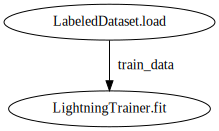

In [6]:
# Instantiate U-Net model
model = UNet()

# ------------ DASF OPERATORS ------------ 
dataset = LabeledDataset(data_path, labels_path)
trainer = LightningTrainer(
    model=model,
    use_gpu=False,      # Do not use GPUs (does not working on jupyter notebook)
    max_epochs=1,
    strategy="ddp_notebook",   # Use DDP strategy (needed only when using jupyter notebooks)
    batch_size=8,
)

# ------------ DASF PIPELINE ------------
executor = DaskPipelineExecutor(
    local=True, use_gpu=False   # Do not use GPUs (does not working on jupyter notebook)
)
pipeline = Pipeline(
    name="pipeline",
    executor=executor,
    verbose=True,
)
pipeline.add(trainer.fit, train_data=dataset)

pipeline.visualize()

Finally, run it!

In [7]:
pipeline.run()

[2024-05-13 21:17:38+0000] INFO - Beginning pipeline run for 'pipeline'
[2024-05-13 21:17:38+0000] INFO - Task 'LabeledDataset.load': Starting task run...
[2024-05-13 21:17:38+0000] INFO - Task 'LabeledDataset.load': Finished task run
[2024-05-13 21:17:38+0000] INFO - Task 'LightningTrainer.fit': Starting task run...


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/trainer/configuration_validator.py:74: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
Initializing distributed: GLOBAL_RANK: 0, MEMBER: 1/1
----------------------------------------------------------------------------------------------------
distributed_backend=gloo
All distributed processes registered. Starting with 1 processes
----------------------------------------------------------------------------------------------------


  | Name    | Type    | Params
------------------------------------
0 | model   | _UNet   | 31.0 M
1 | loss_fn | MSELoss | 0     
------------------------------------
31.0 M    Trainable params
0         Non-trainable params
31.0 M    Total params
124.146   Total estimated model params size (MB)
/usr/local/lib/python3.10/dist-

Training: |          | 0/? [00:00<?, ?it/s]